1. 더미 데이터 불러오기

In [1]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기
selected_columns = [
    "시도명", "시군구명"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns).fillna("")

# 시군구별 데이터 개수 집계
city_counts = df["시군구명"].value_counts().sort_values(ascending=False)
print("경남 시/군별 상가 데이터 개수:")
print(city_counts)

경남 시/군별 상가 데이터 개수:
시군구명
김해시          26565
진주시          19254
양산시          16324
창원시 성산구      13519
거제시          12317
창원시 의창구      11093
창원시 마산합포구     9869
창원시 진해구       8428
창원시 마산회원구     8283
통영시           7385
사천시           6405
밀양시           5737
거창군           3341
남해군           3212
창녕군           3156
함안군           2939
하동군           2856
고성군           2647
함양군           2123
산청군           1995
합천군           1946
의령군           1074
Name: count, dtype: int64


In [2]:
import pandas as pd

# 필요한 컬럼만 선택하여 CSV 읽기 (상위 100줄만)
selected_columns = [
    "상권업종대분류코드", "상권업종대분류명", "상권업종중분류코드", "상권업종중분류명", 
    "상권업종소분류코드", "상권업종소분류명", "시도코드", "시도명", "시군구코드", "시군구명", 
    "행정동코드", "행정동명", "법정동명", "지번주소", "도로명주소", "경도", "위도"
]

df = pd.read_csv("./data/소상공인시장진흥공단_상가(상권)정보_경남_202503.csv", 
                 usecols=selected_columns,
                 #nrows=10000
                 ).fillna("")

# 시군구명이 "남해군"인 데이터만 필터링
cityname = "거창군"
df = df[df["시군구명"] == cityname].reset_index(drop=True)

print(f"{cityname} 데이터 수: {len(df)}개")
print(f"\n{cityname} 내 시군구별 분포:")
print(df["시군구명"].value_counts())

# 텍스트 컬럼 생성 (주소 정보를 결합)
df["text"] = (df["시도명"].str.strip() + " " + 
              df["시군구명"].str.strip() + " " + 
              df["행정동명"].str.strip() + " " + 
              df["상권업종대분류명"].str.strip() + " " + 
              df["상권업종중분류명"].str.strip() + " " + 
              df["상권업종소분류명"].str.strip())

print(f"\n=== {cityname} 상가 데이터 샘플 ===")

print(df.head(2))

거창군 데이터 수: 3341개

거창군 내 시군구별 분포:
시군구명
거창군    3341
Name: count, dtype: int64

=== 거창군 상가 데이터 샘플 ===
  상권업종대분류코드 상권업종대분류명 상권업종중분류코드 상권업종중분류명 상권업종소분류코드 상권업종소분류명  시도코드   시도명  시군구코드  \
0        I2       음식      I203       일식    I20301  일식 회/초밥    48  경상남도  48880   
1        S2    수리·개인      S207    이용·미용    S20701      미용실    48  경상남도  48880   

  시군구명     행정동코드 행정동명 법정동명                     지번주소                도로명주소  \
0  거창군  48880250  거창읍  거창읍  경상남도 거창군 거창읍 중앙리 233-23  경상남도 거창군 거창읍 시장길 22   
1  거창군  48880250  거창읍  거창읍  경상남도 거창군 거창읍 상림리 235-36  경상남도 거창군 거창읍 중앙로 46   

           경도         위도                          text  
0  127.912028  35.685678    경상남도 거창군 거창읍 음식 일식 일식 회/초밥  
1  127.903721  35.684713  경상남도 거창군 거창읍 수리·개인 이용·미용 미용실  


2. 전처리(클렌징)

In [3]:
import re

def clean(txt: str) -> str:
    txt = re.sub(r"http\S+|www\S+", " ", txt)            # URL
    txt = re.sub(r"[^\w가-힣\s]", " ", txt)              # 특수문자
    txt = re.sub(r"\s+", " ", txt).strip()               # 중복 공백
    return txt.lower()

df["clean"] = df["text"].apply(clean)

3. SimCSE 임베딩

In [4]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

MODEL_ID = "BM-K/KoSimCSE-roberta"      # unsupervised 버전
embedder = SentenceTransformer(MODEL_ID)

BATCH = 256
emb_list = []
for i in tqdm(range(0, len(df), BATCH)):
    batch = df["clean"].iloc[i : i + BATCH].tolist()
    embs  = embedder.encode(batch, batch_size=len(batch),
                            normalize_embeddings=True)
    emb_list.extend(embs)
import numpy as np
emb = np.vstack(emb_list).astype("float32")              # (N, 768)

No sentence-transformers model found with name BM-K/KoSimCSE-roberta. Creating a new one with mean pooling.
100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


normalize_embeddings=True → 이미 L2 노멀라이즈된 벡터라 Inner Product = 코사인.

4. FAISS 인덱스 생성

In [5]:
import faiss

d = emb.shape[1]                     # 768
index = faiss.IndexFlatIP(d)         # 작은 데이터셋은 Flat IP로 충분
index.add(emb)                       # 전체 아이디어 삽입

5. 유사 아이디어 검색 함수

In [6]:
def find_similar(query: str, top_k: int = 5):
    q_emb = embedder.encode([clean(query)],
                            normalize_embeddings=True).astype("float32")
    D, I = index.search(q_emb, top_k)      # D: 코사인, I: 행 인덱스
    return list(zip(I[0], D[0]))           # [(idx, score), …]

def find_similar_with_details(query: str, top_k: int = 5):
    """검색 결과와 함께 상가 정보도 보여주는 함수"""
    results = find_similar(query, top_k)
    print(f"검색어: '{query}'")
    print(f"상위 {top_k}개 결과:")
    print("-" * 50)
    
    for i, (idx, score) in enumerate(results, 1):
        row = df.iloc[idx]
        print(f"{i}. 유사도: {score:.3f}")
        print(f"   상호명: {row.get('상호명', 'N/A')}")
        print(f"   업종: {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
        print(f"   위치: {row['시도명']} {row['시군구명']} {row['행정동명']}")
        print(f"   주소: {row['지번주소']}")
        print()

# 실제 상가 데이터에 맞는 검색어로 테스트
print("=== 실제 상가 데이터 검색 테스트 ===")
find_similar_with_details("진주시 꽃집")
print()
find_similar_with_details("김해시 의원")
print()
find_similar_with_details("경상남도 소매")

=== 실제 상가 데이터 검색 테스트 ===
검색어: '진주시 꽃집'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.689
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 거창군 북상면
   주소: 경상남도 거창군 북상면 산수리 81-1

2. 유사도: 0.681
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 거창군 남하면
   주소: 경상남도 거창군 남하면 양항리 1047-3

3. 유사도: 0.678
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 상림리 629-3

4. 유사도: 0.678
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 대평리 931-1

5. 유사도: 0.678
   상호명: N/A
   업종: 소매 > 식물 소매 > 꽃집
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 대평리 916-3


검색어: '김해시 의원'
상위 5개 결과:
--------------------------------------------------
1. 유사도: 0.503
   상호명: N/A
   업종: 보건의료 > 의원 > 이비인후과 의원
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 상림리 796-3

2. 유사도: 0.501
   상호명: N/A
   업종: 보건의료 > 의원 > 한의원
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 대동리 722

3. 유사도: 0.501
   상호명: N/A
   업종: 보건의료 > 의원 > 한의원
   위치: 경상남도 거창군 거창읍
   주소: 경상남도 거창군 거창읍 대동리 889-1

4. 유사도: 0.493
   상호명:

6. HDBSCAN 클러스터링

In [7]:
import hdbscan, joblib, numpy as np

n = len(df)                                     # 현재 데이터 크기
#min_cluster = max(2, int(0.2 * n))              # 20% 또는 최소 2
#min_samples = min(min_cluster, n - 1)

# 관대한 파라미터
min_cluster = 20    # 20개만 모여도 클러스터
min_samples = 10         # 10개 이웃만 있어도 핵심 포인트

clusterer = hdbscan.HDBSCAN(
        metric="euclidean",
        min_cluster_size=min_cluster,
        min_samples=min_samples,
        prediction_data=True
).fit(emb)

df["cluster"] = clusterer.labels_
print(df["cluster"].value_counts())
joblib.dump(clusterer, "hdbscan.pkl")

/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


cluster
-1     659
 49    215
 15    172
 44    161
 0     152
 23    120
 46     79
 32     71
 22     64
 25     61
 41     58
 18     56
 36     55
 7      55
 39     53
 10     52
 3      50
 43     50
 45     47
 12     44
 28     44
 20     43
 47     43
 33     42
 4      41
 27     41
 16     41
 17     40
 21     39
 11     39
 48     38
 13     37
 40     36
 31     35
 35     32
 38     32
 6      31
 34     30
 52     29
 51     29
 42     28
 8      26
 24     26
 37     25
 26     25
 2      24
 1      22
 29     22
 14     22
 30     22
 50     21
 19     21
 5      21
 9      20
Name: count, dtype: int64


['hdbscan.pkl']

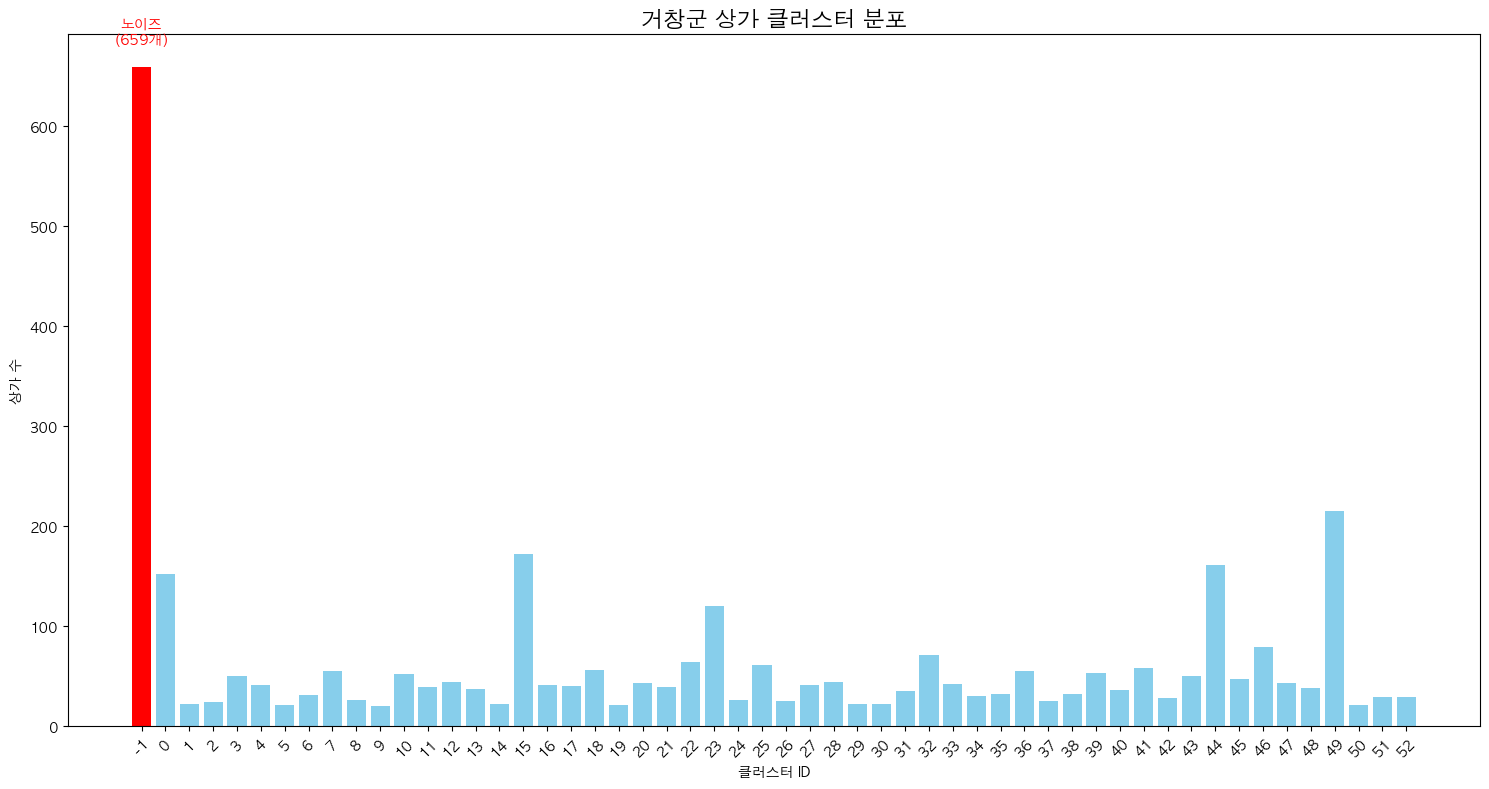

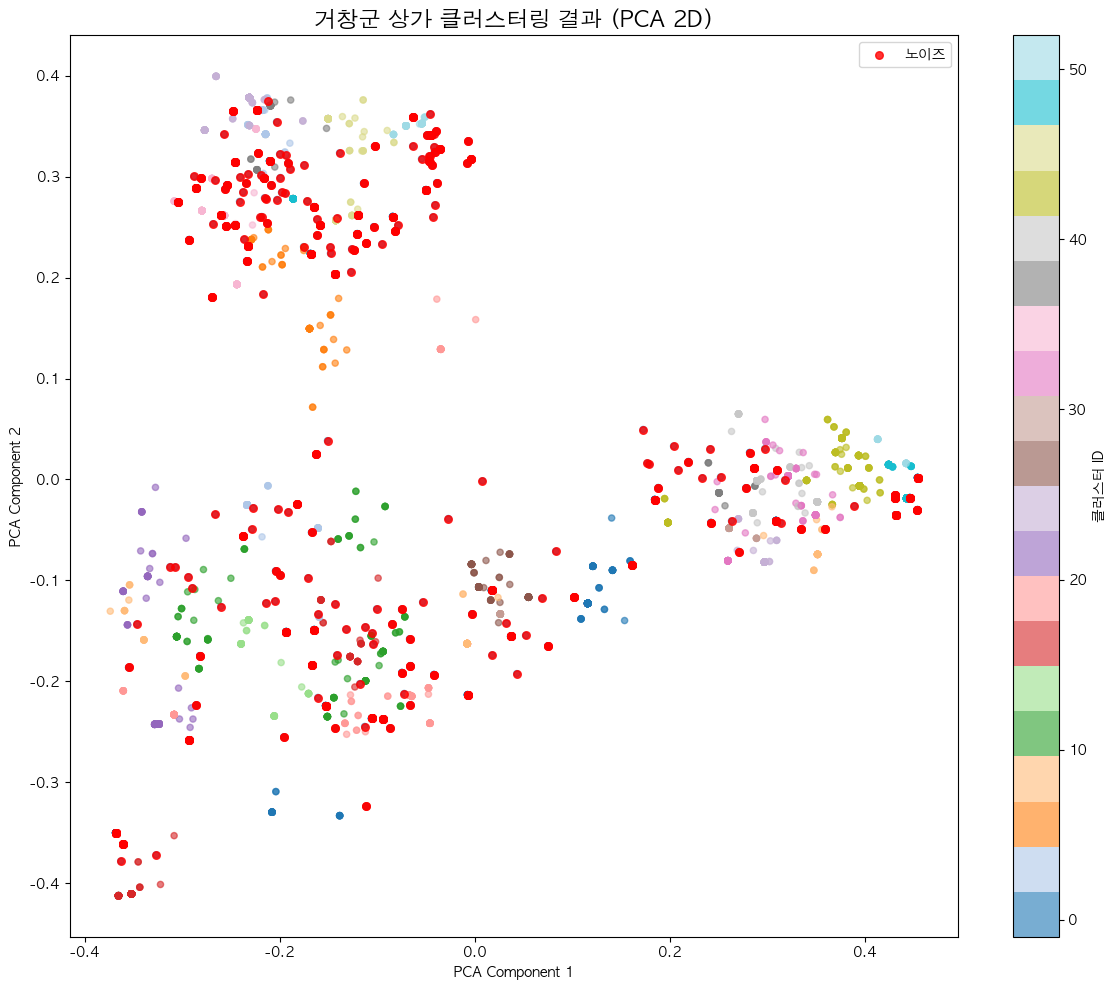

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # macOS용
plt.rcParams['axes.unicode_minus'] = False

# 1. 클러스터 분포 막대 그래프
plt.figure(figsize=(15, 8))
cluster_counts = df['cluster'].value_counts().sort_index()
colors = ['red' if x == -1 else 'skyblue' for x in cluster_counts.index]

plt.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
plt.title(f'{cityname} 상가 클러스터 분포', fontsize=16, fontweight='bold')
plt.xlabel('클러스터 ID')
plt.ylabel('상가 수')
plt.xticks(range(len(cluster_counts)), cluster_counts.index, rotation=45)

# 노이즈 클러스터(-1) 강조
plt.text(0, cluster_counts.iloc[0] + 20, f'노이즈\n({cluster_counts.iloc[0]}개)', 
         ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 2. PCA로 2D 시각화
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=df['cluster'], 
                     cmap='tab20', alpha=0.6, s=20)

# 노이즈 포인트(-1)는 빨간색으로 강조
noise_mask = df['cluster'] == -1
plt.scatter(emb_2d[noise_mask, 0], emb_2d[noise_mask, 1], 
           c='red', alpha=0.8, s=30, label='노이즈')

plt.title(f'{cityname} 상가 클러스터링 결과 (PCA 2D)', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.colorbar(scatter, label='클러스터 ID')
plt.tight_layout()
plt.show()

In [9]:
# 노이즈 상세 분석
cluster_13_data = df[df['cluster'] == -1]

print("=== 노이즈 상세 분석 ===")
print(f"총 상가 수: {len(cluster_13_data)}개")
print(f"전체 대비 비율: {len(cluster_13_data)/len(df)*100:.1f}%")

print("\n1. 업종별 분포:")
print(cluster_13_data['상권업종대분류명'].value_counts())
print("\n   중분류별 분포:")
print(cluster_13_data['상권업종중분류명'].value_counts().head(10))

print("\n2. 지역별 분포:")
print(cluster_13_data['행정동명'].value_counts())

print("\n3. 상세 업종별 분포 (상위 15개):")
print(cluster_13_data['상권업종소분류명'].value_counts().head(15))

print("\n4. 노이즈의 상가 샘플 (처음 10개):")
print("-" * 80)
for idx, row in cluster_13_data.head(10).iterrows():
    print(f"• {row['행정동명']} - {row['상권업종대분류명']} > {row['상권업종중분류명']} > {row['상권업종소분류명']}")
    print(f"  주소: {row['지번주소']}")
    print()

=== 노이즈 상세 분석 ===
총 상가 수: 659개
전체 대비 비율: 19.7%

1. 업종별 분포:
상권업종대분류명
소매         307
음식         128
과학·기술       61
수리·개인       46
숙박          37
예술·스포츠      23
교육          21
보건의료        18
시설관리·임대     18
Name: count, dtype: int64

   중분류별 분포:
상권업종중분류명
한식             70
식료품 소매         67
종합 소매          52
오락용품 소매        36
일반 숙박          35
이용·미용          30
섬유·의복·신발 소매    22
기타 교육          20
일식             16
장식품 소매         16
Name: count, dtype: int64

2. 지역별 분포:
행정동명
거창읍    391
가조면     62
위천면     32
마리면     32
웅양면     30
고제면     26
남상면     24
북상면     22
가북면     17
신원면     10
남하면     10
주상면      3
Name: count, dtype: int64

3. 상세 업종별 분포 (상위 15개):
상권업종소분류명
백반/한정식         58
슈퍼마켓           35
펜션             23
채소/과일 소매업      20
네일숍            19
정육점            17
침구류/커튼 소매업     15
중고 상품 소매업      14
경영 컨설팅업        14
시계/귀금속 소매업     14
일식 회/초밥        13
요가/필라테스 학원     13
문구/회화용품 소매업    12
편의점            12
생수/음료 소매업      12
Name: count, dtype: int64

4. 노이즈의 상가 샘플 (처음 10개):
--------------

In [10]:
# 노이즈 줄이기 위한 HDBSCAN 파라미터 조정 (지원되는 메트릭만 사용)
import hdbscan, joblib, numpy as np

print("=== 노이즈 줄이기 실험 ===")

# 실험 1: 더 관대한 파라미터 (euclidean)
print("\n1. 더 관대한 파라미터로 재실험")
clusterer_1 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=10,      # 20 → 10으로 줄임
    min_samples=5,            # 10 → 5로 줄임
    prediction_data=True,
    cluster_selection_epsilon=0.5,  # 0.3 → 0.5로 증가
    alpha=1.0
).fit(emb)

labels_1 = clusterer_1.labels_
noise_count_1 = len(labels_1[labels_1 == -1])
print(f"노이즈 수: {noise_count_1}개 ({noise_count_1/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_1)) - (1 if -1 in labels_1 else 0)}개")

# 실험 2: 가장 관대한 파라미터
print("\n2. 가장 관대한 파라미터로 재실험")
clusterer_2 = hdbscan.HDBSCAN(
    metric="euclidean",
    min_cluster_size=5,       # 최소 클러스터 크기를 5로
    min_samples=3,            # 최소 샘플 수를 3으로
    prediction_data=True,
    cluster_selection_epsilon=0.6,  # 임계값을 0.6으로
    alpha=1.0
).fit(emb)

labels_2 = clusterer_2.labels_
noise_count_2 = len(labels_2[labels_2 == -1])
print(f"노이즈 수: {noise_count_2}개 ({noise_count_2/len(df)*100:.1f}%)")
print(f"클러스터 수: {len(set(labels_2)) - (1 if -1 in labels_2 else 0)}개")

=== 노이즈 줄이기 실험 ===

1. 더 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 65개 (1.9%)
클러스터 수: 35개

2. 가장 관대한 파라미터로 재실험


/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leeyoungho/miniforge3/envs/ai_3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


노이즈 수: 4개 (0.1%)
클러스터 수: 11개


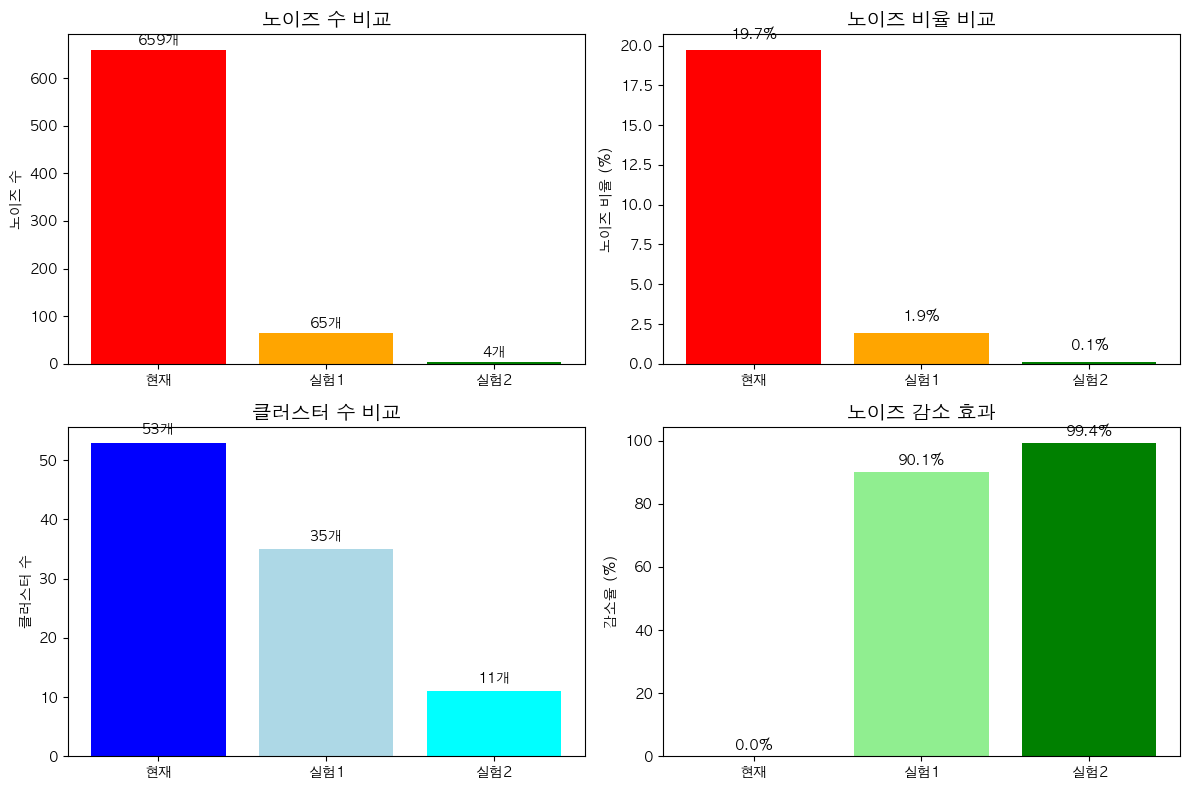

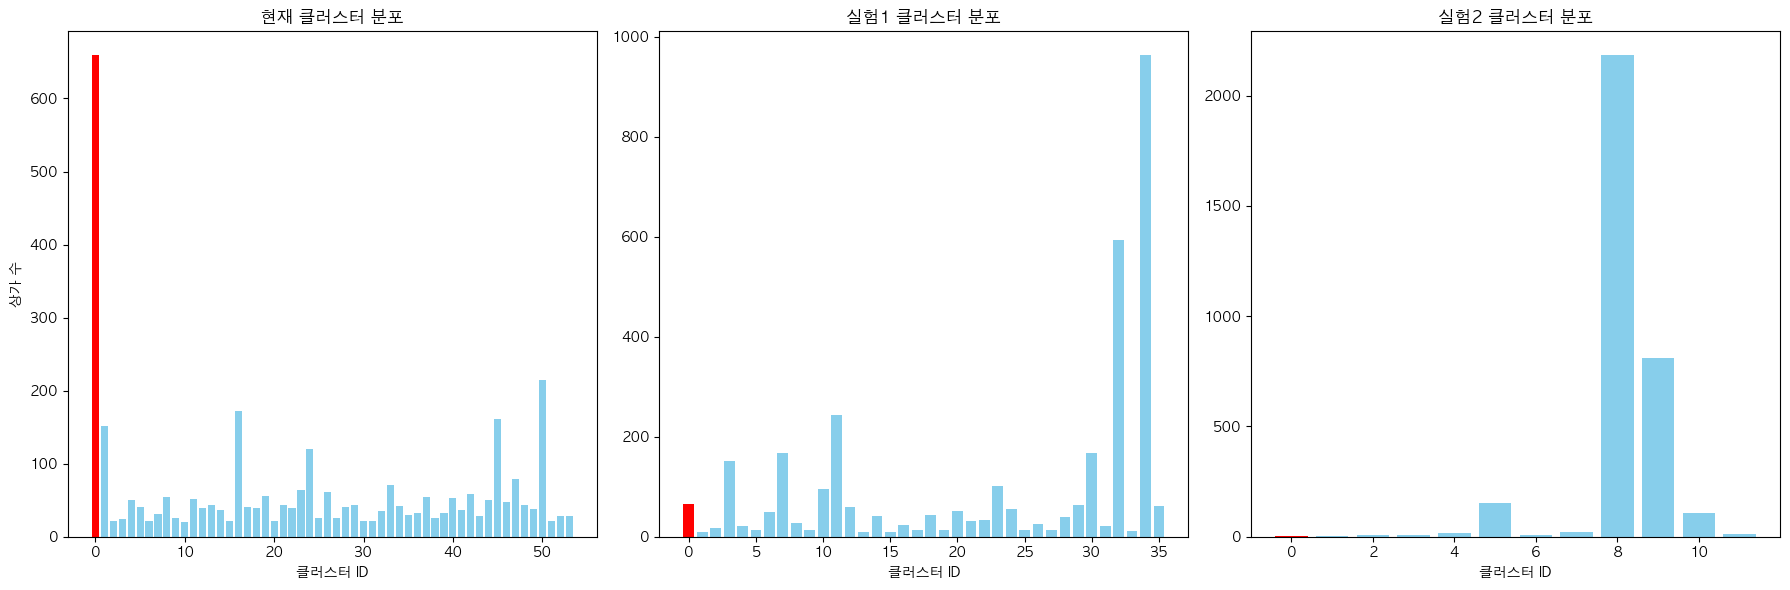

In [11]:
# 노이즈 줄이기 실험 결과 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 실험 결과 데이터 준비
experiment_names = ['현재', '실험1', '실험2']
noise_counts = [
    len(df[df['cluster'] == -1]),  # 현재
    noise_count_1,                 # 실험1
    noise_count_2                  # 실험2
]
cluster_counts = [
    len(set(df['cluster'])) - 1,   # 현재
    len(set(labels_1)) - (1 if -1 in labels_1 else 0),  # 실험1
    len(set(labels_2)) - (1 if -1 in labels_2 else 0)   # 실험2
]

# 1. 노이즈 수 비교 그래프
plt.figure(figsize=(12, 8))

# 서브플롯 1: 노이즈 수 비교
plt.subplot(2, 2, 1)
bars1 = plt.bar(experiment_names, noise_counts, color=['red', 'orange', 'green'])
plt.title('노이즈 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 수')
for bar, count in zip(bars1, noise_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 2: 노이즈 비율 비교
plt.subplot(2, 2, 2)
noise_ratios = [count/len(df)*100 for count in noise_counts]
bars2 = plt.bar(experiment_names, noise_ratios, color=['red', 'orange', 'green'])
plt.title('노이즈 비율 비교', fontsize=14, fontweight='bold')
plt.ylabel('노이즈 비율 (%)')
for bar, ratio in zip(bars2, noise_ratios):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{ratio:.1f}%', ha='center', va='bottom', fontweight='bold')

# 서브플롯 3: 클러스터 수 비교
plt.subplot(2, 2, 3)
bars3 = plt.bar(experiment_names, cluster_counts, color=['blue', 'lightblue', 'cyan'])
plt.title('클러스터 수 비교', fontsize=14, fontweight='bold')
plt.ylabel('클러스터 수')
for bar, count in zip(bars3, cluster_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}개', ha='center', va='bottom', fontweight='bold')

# 서브플롯 4: 개선 효과
plt.subplot(2, 2, 4)
improvement = [(noise_counts[0] - count)/noise_counts[0]*100 for count in noise_counts]
bars4 = plt.bar(experiment_names, improvement, color=['gray', 'lightgreen', 'green'])
plt.title('노이즈 감소 효과', fontsize=14, fontweight='bold')
plt.ylabel('감소율 (%)')
for bar, imp in zip(bars4, improvement):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{imp:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. 실험별 클러스터 분포 비교
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 현재 클러스터 분포
current_clusters = df['cluster'].value_counts().sort_index()
axes[0].bar(range(len(current_clusters)), current_clusters.values, 
            color=['red' if x == -1 else 'skyblue' for x in current_clusters.index])
axes[0].set_title('현재 클러스터 분포', fontweight='bold')
axes[0].set_xlabel('클러스터 ID')
axes[0].set_ylabel('상가 수')

# 실험1 클러스터 분포
exp1_clusters = pd.Series(labels_1).value_counts().sort_index()
axes[1].bar(range(len(exp1_clusters)), exp1_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp1_clusters.index])
axes[1].set_title('실험1 클러스터 분포', fontweight='bold')
axes[1].set_xlabel('클러스터 ID')

# 실험2 클러스터 분포
exp2_clusters = pd.Series(labels_2).value_counts().sort_index()
axes[2].bar(range(len(exp2_clusters)), exp2_clusters.values,
            color=['red' if x == -1 else 'skyblue' for x in exp2_clusters.index])
axes[2].set_title('실험2 클러스터 분포', fontweight='bold')
axes[2].set_xlabel('클러스터 ID')

plt.tight_layout()
plt.show()

In [12]:
selected_result = '실험1'  # '현재', '실험1', '실험2' 중 선택

if selected_result == '실험1':
    df['cluster'] = labels_1
    clusterer = clusterer_1
elif selected_result == '실험2':
    df['cluster'] = labels_2
    clusterer = clusterer_2
# '현재'는 이미 반영되어 있음

print(f"\n[{selected_result}] 결과로 데이터프레임이 업데이트되었습니다.")
print(df['cluster'].value_counts().sort_index())


[실험1] 결과로 데이터프레임이 업데이트되었습니다.
cluster
-1      65
 0      10
 1      18
 2     152
 3      22
 4      14
 5      50
 6     168
 7      27
 8      14
 9      96
 10    243
 11     60
 12     10
 13     41
 14     10
 15     23
 16     14
 17     43
 18     13
 19     52
 20     32
 21     33
 22    102
 23     55
 24     14
 25     26
 26     13
 27     39
 28     64
 29    168
 30     21
 31    594
 32     11
 33    963
 34     61
Name: count, dtype: int64


In [13]:
print(f"\n=== {selected_result} 클러스터별 주요 업종/지역 분석 ===")
for cluster_id in sorted(df['cluster'].unique()):
    if cluster_id != -1:  # 노이즈 제외
        cluster_data = df[df['cluster'] == cluster_id]
        print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개):")
        # 주요 업종 대분류
        major_business = cluster_data['상권업종대분류명'].value_counts().head(3)
        print(f"  주요 업종: {dict(major_business)}")
        # 주요 지역
        major_area = cluster_data['행정동명'].value_counts().head(3)
        print(f"  주요 지역: {dict(major_area)}")


=== 실험1 클러스터별 주요 업종/지역 분석 ===

클러스터 0 (10개):
  주요 업종: {'예술·스포츠': 10}
  주요 지역: {'거창읍': 10}

클러스터 1 (18개):
  주요 업종: {'보건의료': 18}
  주요 지역: {'거창읍': 17, '가조면': 1}

클러스터 2 (152개):
  주요 업종: {'음식': 152}
  주요 지역: {'거창읍': 112, '가조면': 16, '위천면': 9}

클러스터 3 (22개):
  주요 업종: {'수리·개인': 22}
  주요 지역: {'거창읍': 20, '가조면': 2}

클러스터 4 (14개):
  주요 업종: {'과학·기술': 14}
  주요 지역: {'거창읍': 11, '남상면': 1, '남하면': 1}

클러스터 5 (50개):
  주요 업종: {'부동산': 50}
  주요 지역: {'거창읍': 45, '가조면': 4, '마리면': 1}

클러스터 6 (168개):
  주요 업종: {'숙박': 168}
  주요 지역: {'북상면': 48, '거창읍': 36, '위천면': 25}

클러스터 7 (27개):
  주요 업종: {'과학·기술': 27}
  주요 지역: {'거창읍': 27}

클러스터 8 (14개):
  주요 업종: {'소매': 14}
  주요 지역: {'거창읍': 13, '가조면': 1}

클러스터 9 (96개):
  주요 업종: {'예술·스포츠': 96}
  주요 지역: {'거창읍': 67, '위천면': 8, '가조면': 8}

클러스터 10 (243개):
  주요 업종: {'수리·개인': 243}
  주요 지역: {'거창읍': 225, '가조면': 10, '위천면': 3}

클러스터 11 (60개):
  주요 업종: {'과학·기술': 60}
  주요 지역: {'거창읍': 57, '가조면': 2, '웅양면': 1}

클러스터 12 (10개):
  주요 업종: {'과학·기술': 10}
  주요 지역: {'거창읍': 9, '가북면': 1}

클러스터 13 (41개):
  

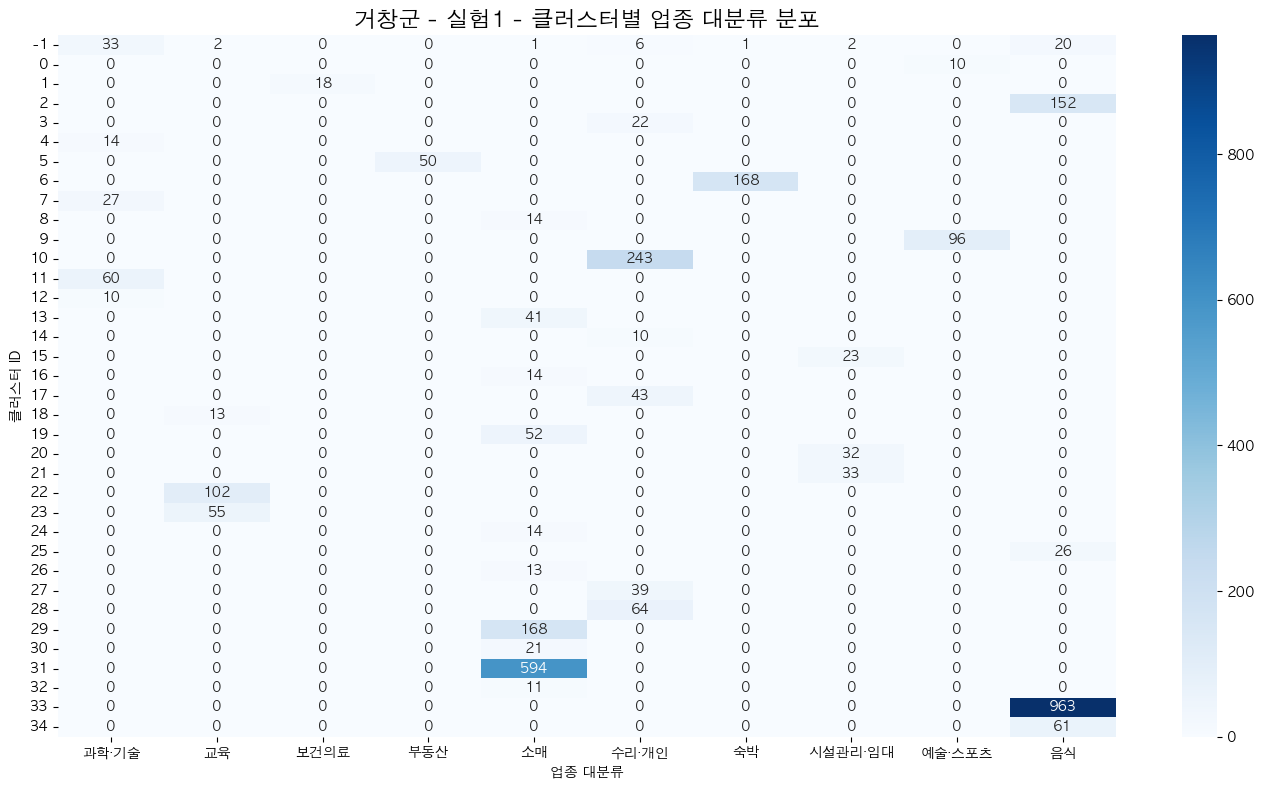

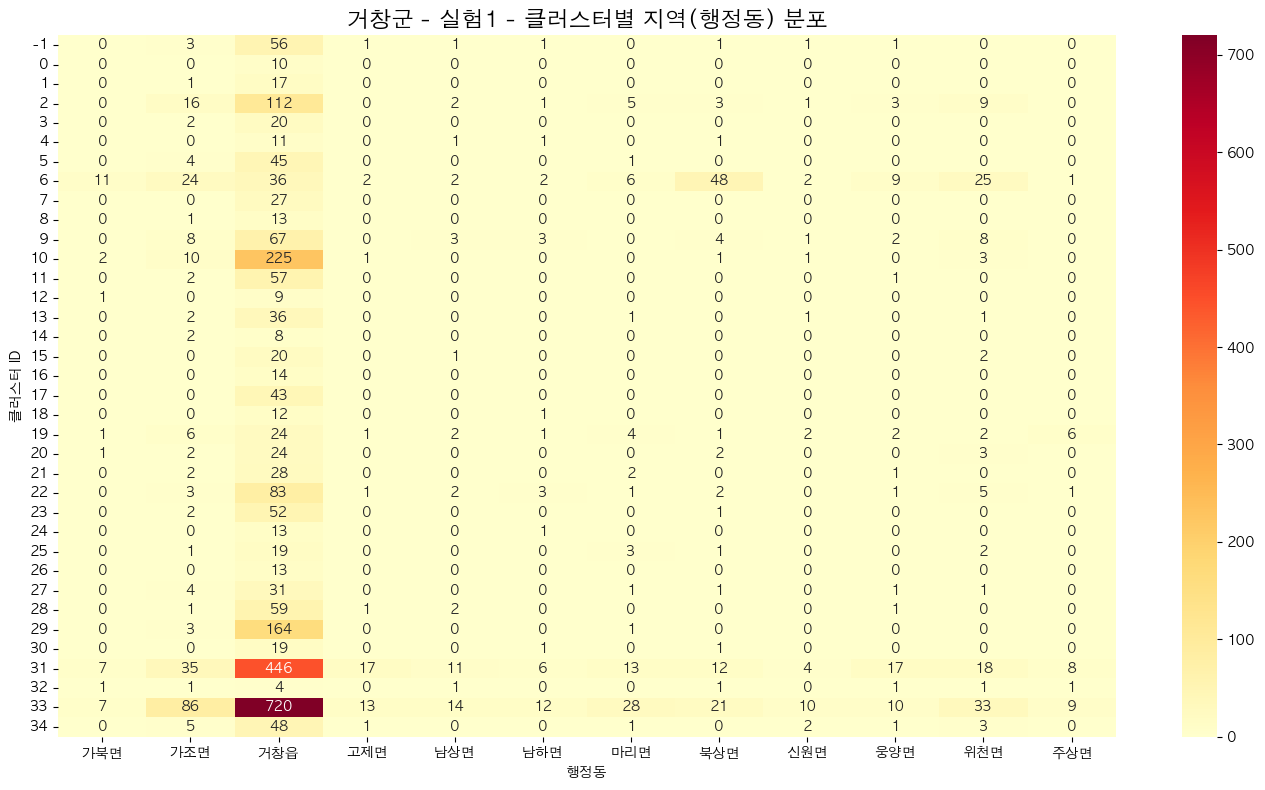

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클러스터별 업종 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_business_pivot = pd.crosstab(df['cluster'], df['상권업종대분류명'])
sns.heatmap(cluster_business_pivot, annot=True, fmt='d', cmap='Blues')
plt.title(f'{cityname} - {selected_result} - 클러스터별 업종 대분류 분포', fontsize=16, fontweight='bold')
plt.xlabel('업종 대분류')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

# 클러스터별 지역 분포 히트맵
plt.figure(figsize=(14, 8))
cluster_area_pivot = pd.crosstab(df['cluster'], df['행정동명'])
sns.heatmap(cluster_area_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title(f'{cityname} - {selected_result} - 클러스터별 지역(행정동) 분포', fontsize=16, fontweight='bold')
plt.xlabel('행정동')
plt.ylabel('클러스터 ID')
plt.tight_layout()
plt.show()

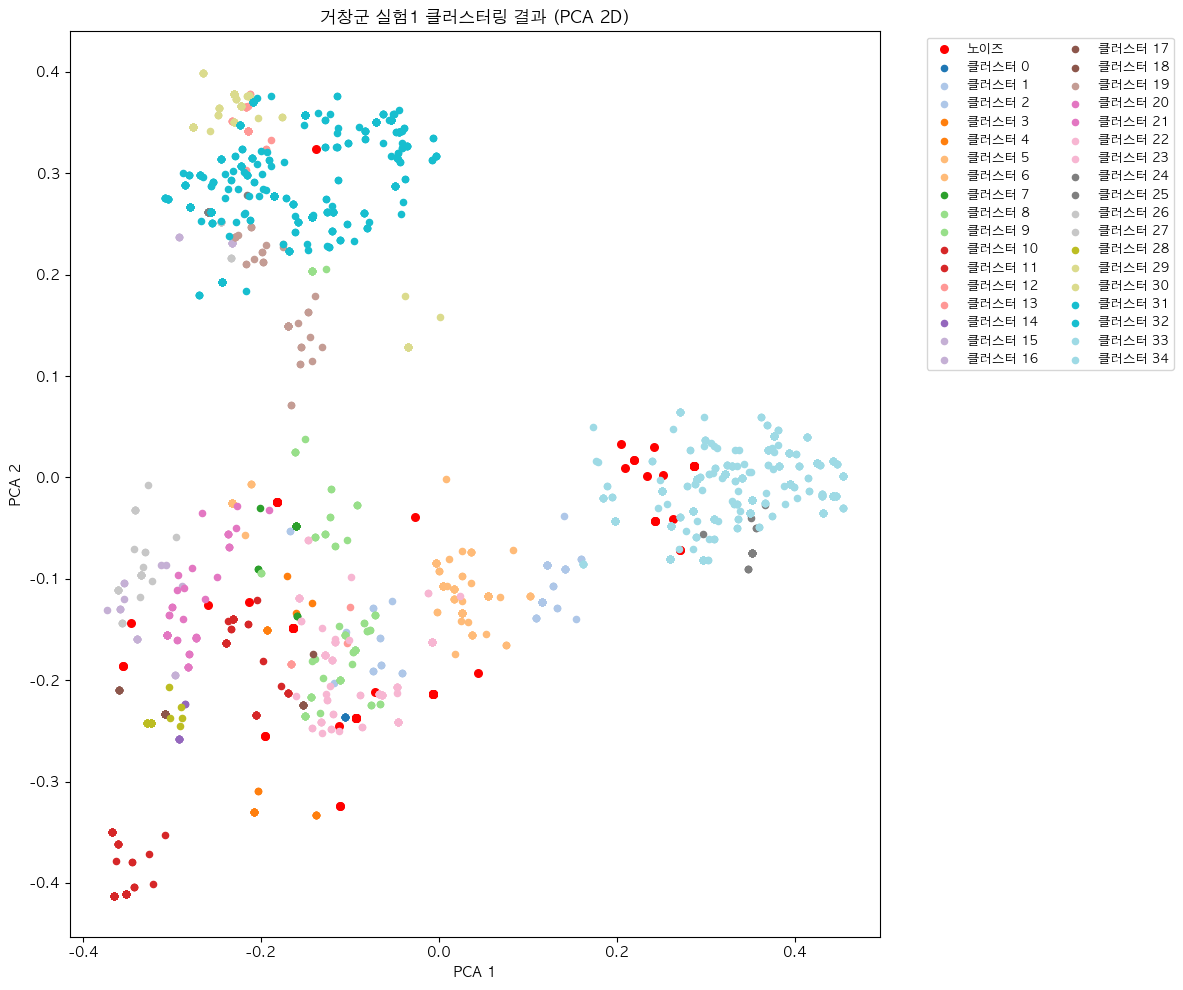

In [15]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(emb)

plt.figure(figsize=(12, 10))
unique_clusters = np.unique(df['cluster'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for i, cluster_id in enumerate(unique_clusters):
    mask = df['cluster'] == cluster_id
    if cluster_id == -1:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], c='red', s=30, label='노이즈')
    else:
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], color=colors[i], s=20, label=f'클러스터 {cluster_id}')

plt.title(f'{cityname} 실험1 클러스터링 결과 (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

-----

여기부터는 .py 에서 진행

7. 새 글 추가 → 실시간 검색 + 인덱스 갱신

In [16]:
def add_idea(new_row: dict, search_k: int = 5):
    """
    새 아이디어 1건을
      1) 전처리·임베딩
      2) FAISS 검색 → 유사도 top-k 반환
      3) 인덱스·데이터프레임·임베딩 배열 업데이트
    """
    global emb, df, index

    # 1) 전처리 + 임베딩
    cleaned = clean(new_row["title"] + " " + new_row["body"])
    vec     = embedder.encode([cleaned], normalize_embeddings=True).astype("float32")

    # 2) 유사도 검색
    D, I = index.search(vec, search_k)
    similar = [(int(idx), float(score)) for idx, score in zip(I[0], D[0])]

    # 3-A) 인덱스·임베딩 배열 업데이트
    index.add(vec)                          # FAISS에 즉시 반영
    emb = np.vstack([emb, vec])             # ndarray 확장

    # 3-B) 데이터프레임 업데이트
    #     ★ 여기서 오류가 났던 부분 → 중괄호 개수 수정
    df = pd.concat(
        [df, pd.DataFrame([ new_row | {"clean": cleaned} ])],
        ignore_index=True
    )

    return similar

Note: HDBSCAN은 증분 학습이 불가하므로
cron or Airflow로 5분마다 전체 재빌드 (clusterer.fit(emb))를 돌리면 됩니다.

8. 프론트 연동 초간단 API

In [17]:
import sys
!{str(sys.executable)} -m pip install fastapi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
from fastapi import FastAPI
app = FastAPI()

@app.post("/submit")
def submit(idea: dict):
    sim = add_idea(idea)
    # 코사인 0.7↑ + 같은 cluster 아이템만 추천
    recs = [idx for idx, sc in sim if sc > 0.7 and
            df.loc[idx, "cluster"] == df.iloc[-1]["cluster"]]
    return {"similar_ids": recs}

In [19]:
import sys
!{str(sys.executable)} -m pip install fastapi uvicorn pydantic[dotenv] requests

zsh:1: no matches found: pydantic[dotenv]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
